In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pandas_summary import DataFrameSummary
from pathlib import Path

import os, math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()
os.chdir('/home/krivas/projects/analysis-project/')
from src.utils import convert_int, convert_date,\
                        add_median_features, add_date_diffs, add_days_count, add_date_features,\
                        make_set, run_model, apply_cats


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
DATA        = Path('data')
RAW         = DATA/'raw'
PROCESSED   = DATA/'processed'

# Reading data

In [4]:
csv = pd.read_csv(PROCESSED/'HistoricoJob.csv')

In [5]:
csv.columns

Index(['Id_HistoricoJob', 'Id_Job', 'Id_Malla', 'Fecha_Carga_Scheduler',
       'Fecha_Ejec_Inicio', 'Fecha_Ejec_Fin', 'Duracion', 'Promedio', 'Agente',
       'Mxrc', 'Maxcmpc', 'Grupo', 'Force_Complete', 'CCF', 'Estado',
       'duracion_int', 'promedio_int', 'Fecha_Ejec_Inicio_Int',
       'Hora_Ejec_Inicio_Int', 'Fecha_Ejec_Fin_Int', 'Hora_Ejec_Fin_Int',
       'DiaSemana', 'hubo_error'],
      dtype='object')

In [6]:
target_date = int(csv.Fecha_Ejec_Inicio_Int.max())
start_date = 20180401

In [7]:
%%time
days_data = []
for date in range(start_date, target_date + 1):
    if date in csv.Fecha_Ejec_Inicio_Int.unique():
        days_data.append(make_set(csv.loc[csv['Fecha_Ejec_Inicio_Int'] == date], csv.loc[(csv['Fecha_Ejec_Inicio_Int'] == target_date) & (csv['hubo_error'] == 0)]))

CPU times: user 1min 58s, sys: 120 ms, total: 1min 58s
Wall time: 1min 59s


# Preprocessing

In [18]:
from tqdm import tqdm

In [19]:
%%time
for temp in tqdm(days_data):
    add_date_diffs(temp, csv)
    add_days_count(temp, csv)
    add_date_features(temp)
    add_median_features(temp, csv, 3)

100%|██████████| 43/43 [1:24:17<00:00, 117.62s/it]

CPU times: user 1h 22min 1s, sys: 2min 15s, total: 1h 24min 17s
Wall time: 1h 24min 17s


In [34]:
from src.utils import add_volume_jobs_features
for temp in tqdm(days_data):
    add_volume_jobs_features(temp, csv, 3)

100%|██████████| 43/43 [50:49<00:00, 70.93s/it]


In [ ]:
from src.utils import add_hour_features
for temp in tqdm(days_data):
    add_hour_features(temp, csv, 3)

In [14]:
%%time
# Adding biases
from surprise import dump

svd = dump.load(PROCESSED/'svd_15.dump')[1]

CPU times: user 72 ms, sys: 4 ms, total: 76 ms
Wall time: 76 ms


In [70]:
for temp in tqdm(days_data):
    temp.drop(['volumen_por_hora_dia', 'volumen_por_hora_semana'], inplace=True, axis=1)

100%|██████████| 43/43 [00:00<00:00, 413.13it/s]


In [76]:
cat_cols = ['Id_Job', 'Id_Malla']
for temp in tqdm(days_data):
    for col in cat_cols:
        temp[col] = temp[col].astype('category').cat.codes

100%|██████████| 43/43 [00:00<00:00, 90.76it/s]


In [77]:
days_data[0].head()

,Fecha_Ejec_Inicio_Int,Id_Job,Id_Malla,Hora_Ejec_Inicio_Int,duracion_int,DaysSinceMainframeOp,DaysSinceMainframeOpFail,DaysCountMainframeOp,DaysCountMainframeOpFail,DiaSemana,promedio_por_dia,promedio_por_semana,promedio_por_mes_dia,promedio_por_mes_semana,promedio_por_semana_anterior,promedio_por_dia_anterior,tiempo,promedio_por_hora_dia,promedio_por_hora_semana,promedio_por_hora_mes_dia,promedio_por_hora_mes_semana,promedio_hora_por_semana_anterior,promedio_por_hora_dia_anterior
0,20180401.0,0,1,4414.0,7.0,292,274,246,0,6,NaN,8.750000,NaN,9.300000,NaN,11.666667,0,NaN,8.750000,NaN,9.300000,NaN,11.666667
1,20180401.0,1,223,54600.0,0.0,292,274,593,0,6,0.0,0.000000,0.000000,0.047619,0.0,0.000000,2,0.0,0.000000,0.0,0.047619,0.0,0.000000
2,20180401.0,2,617,12600.0,0.0,121,274,2,0,6,NaN,NaN,NaN,1.000000,NaN,NaN,0,NaN,NaN,NaN,1.000000,NaN,NaN
3,20180401.0,3,617,12520.0,0.0,121,274,2,0,6,NaN,NaN,NaN,1.000000,NaN,NaN,0,NaN,NaN,NaN,1.000000,NaN,NaN
4,20180401.0,4,8,14401.0,4.0,292,274,296,0,6,6.0,5.190476,4.583333,8.750000,5.0,6.000000,0,6.0,5.190476,5.1,8.914634,5.0,6.000000


# Model

In [21]:
from src.utils import run_model
from lightgbm import LGBMRegressor
import lightgbm

In [78]:
target_col = 'duracion_int'
pred_col = 'Prediccion'
id_cols = ['Fecha_Ejec_Inicio_Int', 'Id_Job', 'Id_Malla', 'Hora_Ejec_Inicio_Int']
metric_names = ['mae']

In [79]:
days_data[len(days_data) - 1][pred_col] = 0

In [80]:
%%time
results = None
output = []
for i, w in enumerate(days_data[1:]):
    train, val, test = pd.concat(days_data[:i+1], axis=0), w, days_data[-1]
    
    X_train, y_train = train.drop(id_cols + [target_col], axis=1), \
                       train[target_col]
    if pred_col in val.columns: # when test acts as validation
        X_val, y_val = None, None
    else:
        X_val, y_val = val.drop(id_cols + [target_col], axis=1), \
                       val[target_col]
    X_test = test.drop(id_cols + [target_col, pred_col], axis=1)
    y_test, _, results, model = run_model(
            LGBMRegressor(n_estimators=400, max_depth=50, num_leaves=30),
            X_train, y_train, X_val, y_val, X_test,
            metric_names, results,
            early_stopping=True)
    output.append([y_test, model])

[1]	valid_0's l1: 1800.23
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 1649.18
[3]	valid_0's l1: 1513.45
[4]	valid_0's l1: 1382.9
[5]	valid_0's l1: 1273.93
[6]	valid_0's l1: 1168.83
[7]	valid_0's l1: 1079.75
[8]	valid_0's l1: 1000.54
[9]	valid_0's l1: 922.124
[10]	valid_0's l1: 858.584
[11]	valid_0's l1: 795.826
[12]	valid_0's l1: 744.039
[13]	valid_0's l1: 693.293
[14]	valid_0's l1: 651.35
[15]	valid_0's l1: 609.853
[16]	valid_0's l1: 575.642
[17]	valid_0's l1: 543.113
[18]	valid_0's l1: 515.814
[19]	valid_0's l1: 490.712
[20]	valid_0's l1: 468.291
[21]	valid_0's l1: 448.022
[22]	valid_0's l1: 429.679
[23]	valid_0's l1: 414.105
[24]	valid_0's l1: 399.729
[25]	valid_0's l1: 387.703
[26]	valid_0's l1: 376.364
[27]	valid_0's l1: 366.005
[28]	valid_0's l1: 356.993
[29]	valid_0's l1: 348.164
[30]	valid_0's l1: 343.414
[31]	valid_0's l1: 346.572
[32]	valid_0's l1: 341.484
[33]	valid_0's l1: 342.169
[34]	valid_0's l1: 343.625
[35]	valid_0's l1: 340.196
[36]

249214.35698348636 160.30860644698745


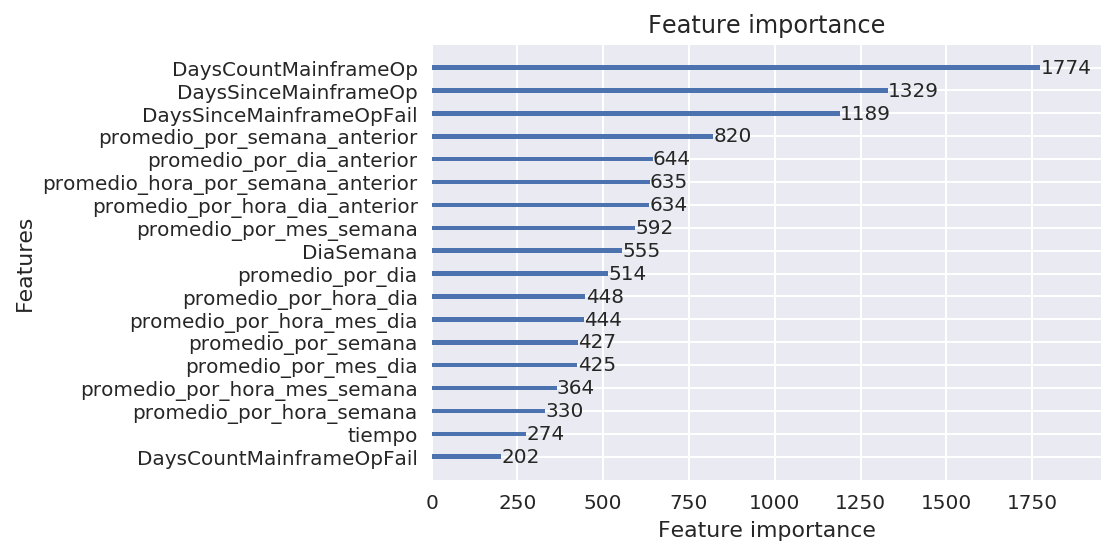

In [25]:
from sklearn.metrics import mean_absolute_error
# Baseline
y_test = np.mean([x[0] for x in output], axis=0)
print(mean_squared_error(days_data[-1].duracion_int, y_test), mean_absolute_error(days_data[-1].duracion_int, y_test))
lightgbm.plot_importance(model)

2243477.0544858202 451.937046003475


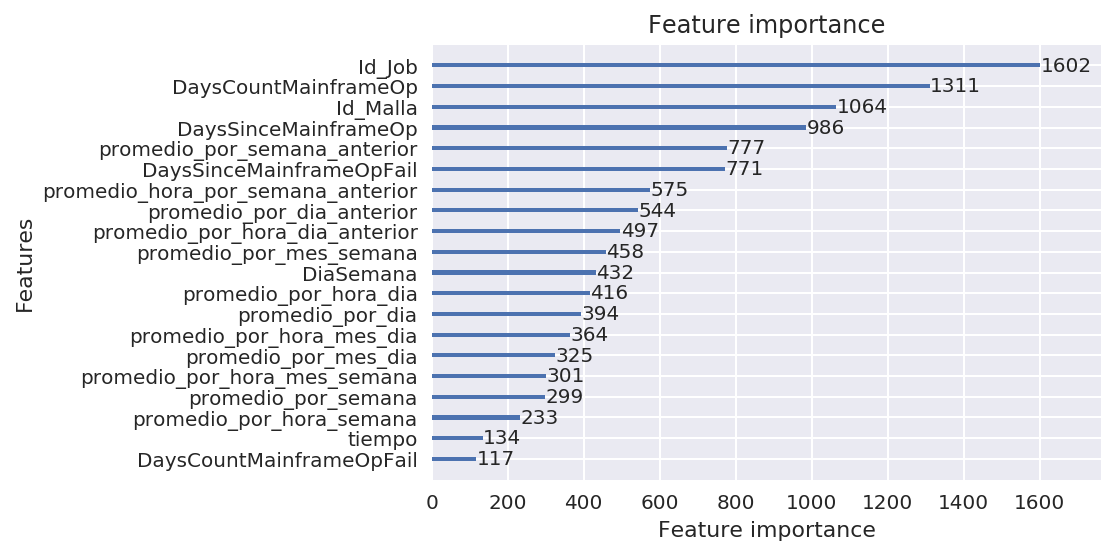

In [81]:
from sklearn.metrics import mean_absolute_error
# Baseline
y_test = np.mean([x[0] for x in output], axis=0)
print(mean_squared_error(days_data[-1].duracion_int, y_test), mean_absolute_error(days_data[-1].duracion_int, y_test))
lightgbm.plot_importance(model)

2554064.8612452103 471.76533025673945


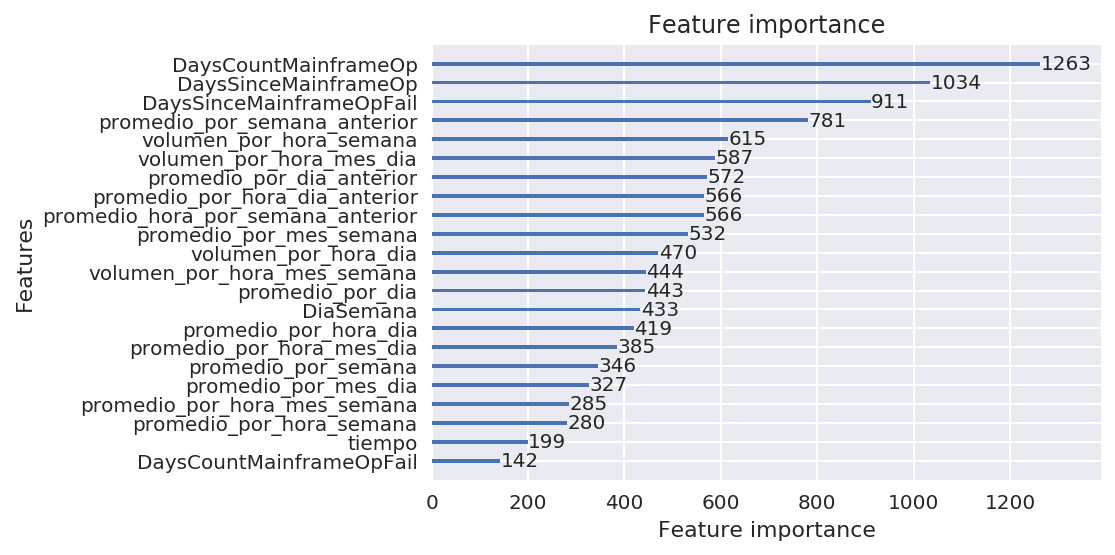

In [64]:
from sklearn.metrics import mean_absolute_error
# Baseline
y_test = np.mean([x[0] for x in output], axis=0)
print(mean_squared_error(days_data[-1].duracion_int, y_test), mean_absolute_error(days_data[-1].duracion_int, y_test))
lightgbm.plot_importance(model)

0.0 0.0


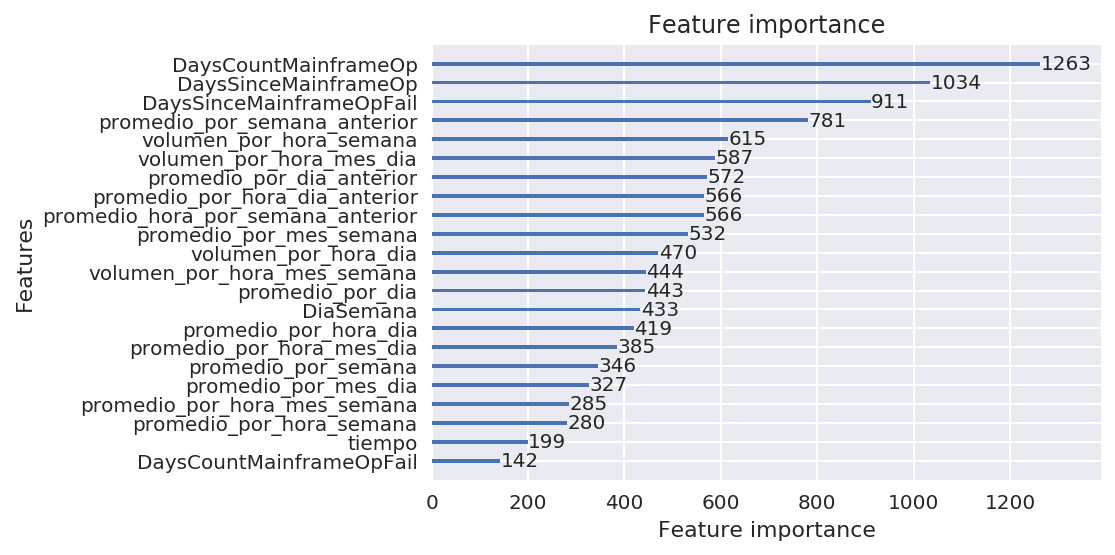

In [53]:
test[target_col] = 0
total = 0
n_weeks = 5
jump = 1.25
dif = 0.5
acum = 1
mul = 0
for ix in range(len(results)):
    if ix % n_weeks == 0:
        acum += dif
        mul = mul + acum
    test[target_col] += (mul) * output[ix][0]
    total += mul
test[target_col] /= total
print(mean_squared_error(days_data[-1].duracion_int, test[target_col]), mean_absolute_error(days_data[-1].duracion_int, test[target_col]))
lightgbm.plot_importance(model)

In [61]:
y_test

array([ 45.24702668,  96.7342016 , 101.69782076, ...,  35.56955225,
        45.28861513,  45.28861513])

In [62]:
output[0]

[array([ 4.11064535, 63.1540707 , 57.79579312, ...,  2.61243223,
         5.9464864 ,  5.9464864 ]),
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=50, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=400,
        n_jobs=-1, num_leaves=30, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)]

In [43]:
np.array(days_data[-1].duracion_int)

array([ 0., 57., 18., ...,  2.,  0.,  0.])

227790.61961027054 167.30085169610274


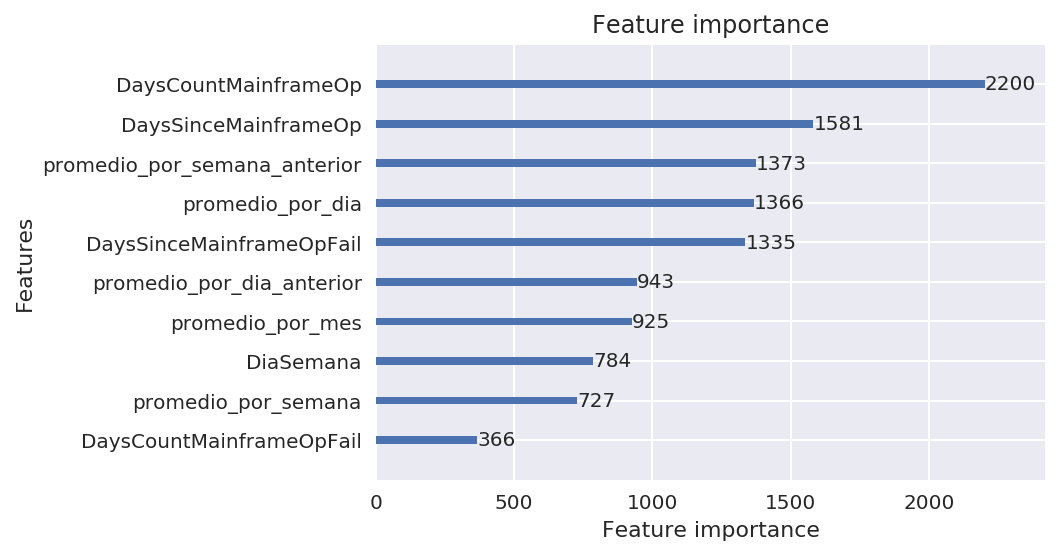

In [26]:
from sklearn.metrics import mean_absolute_error
# Baseline
y_test = np.mean([x[0] for x in output], axis=0)
print(mean_squared_error(days_data[-1].duracion_int, y_test), mean_absolute_error(days_data[-1].duracion_int, y_test))
lightgbm.plot_importance(model)

243982.77237166945 165.13641814815855


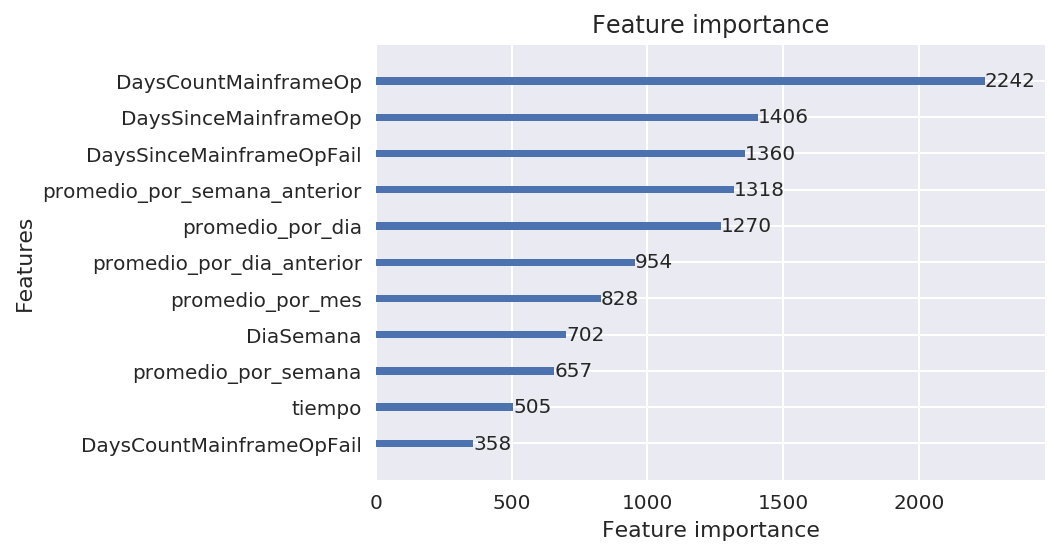

In [34]:
from sklearn.metrics import mean_absolute_error
# with time
y_test = np.mean([x[0] for x in output], axis=0)
print(mean_squared_error(days_data[-1].duracion_int, y_test), mean_absolute_error(days_data[-1].duracion_int, y_test))
lightgbm.plot_importance(model)

250134.0351180824 170.45517986670245


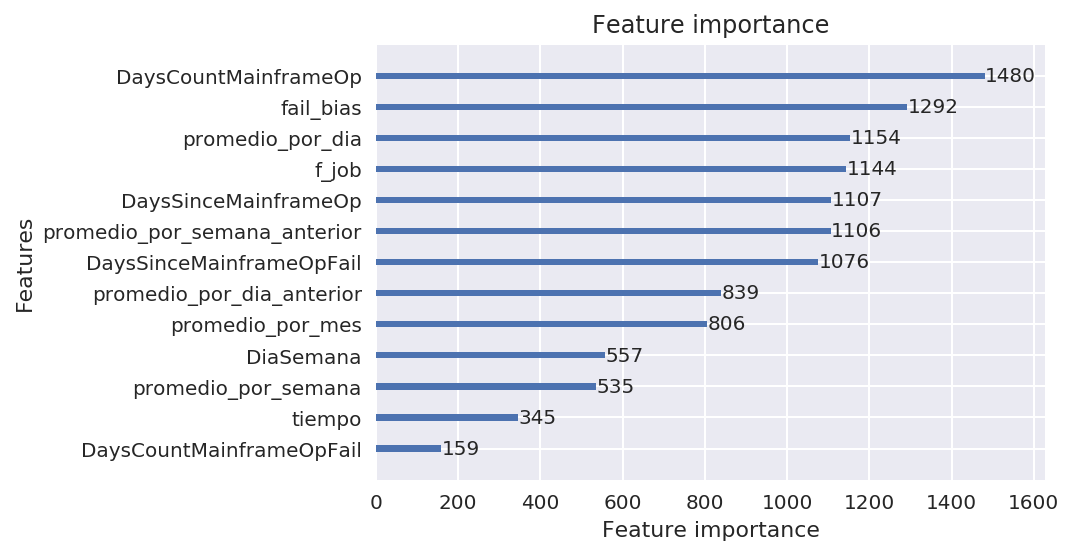

In [38]:
from sklearn.metrics import mean_absolute_error
# fail bias, id_job, time
y_test = np.mean([x[0] for x in output], axis=0)
print(mean_squared_error(days_data[-1].duracion_int, y_test), mean_absolute_error(days_data[-1].duracion_int, y_test))
lightgbm.plot_importance(model)

244477.1155411707 161.76100631914443


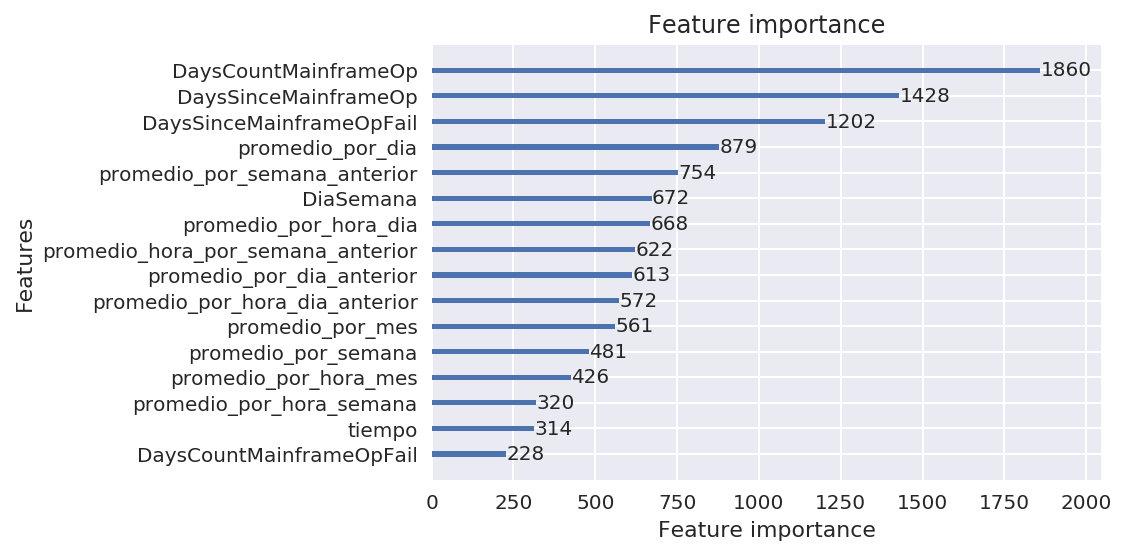

In [77]:
from sklearn.metrics import mean_absolute_error
# with time features
y_test = np.mean([x[0] for x in output], axis=0)
print(mean_squared_error(days_data[-1].duracion_int, y_test), mean_absolute_error(days_data[-1].duracion_int, y_test))
lightgbm.plot_importance(model)

266500.247896482 195.46130788321756


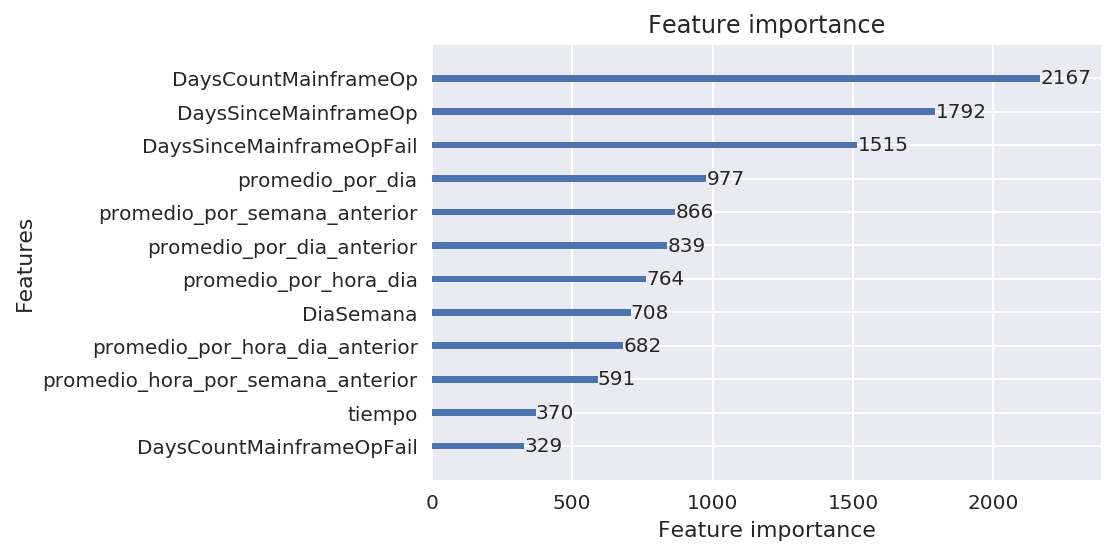

In [84]:
from sklearn.metrics import mean_absolute_error
# with features cropped
y_test = np.mean([x[0] for x in output], axis=0)
print(mean_squared_error(days_data[-1].duracion_int, y_test), mean_absolute_error(days_data[-1].duracion_int, y_test))
lightgbm.plot_importance(model)